In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import progressbar
import scipy.io as sio
import scipy.spatial.distance as ssd
import seaborn as sns

from gaussian_kde import gaussian_kde
from wpca import PCA, WPCA
from IPython.core.display import display, HTML
from mat_handler import import_scored_file_hdf5
from mat2py import mat2py
from skimage import transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
import sklearn.manifold
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from scipy.stats import wasserstein_distance as wd

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
labeled = pd.read_csv('rr_sane.csv')
labeled = labeled.drop('Unnamed: 0',1)

novel = pd.read_csv('novel_data.csv')
novel = novel.drop('Unnamed: 0',1)

# Introduction

Exocytic events of transmembrane receptors are readily visible using superecliptic pHluorin-tagged (SpH) cargo. Previously, our lab has used simple count analyses to look for changes in exocytic rate across a variety of manipulations. Although powerful, this analysis has not taken into account the massive heterogeneity that can be seen when comparing exocytic events either within or across different receptor cargos. We can see multiples types of events, such as events with a long plateau, bright fast events, and dim events:

In [131]:
b2_events, buffer = import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/UM Drive/Data/Puffs Analysis/Rachel B2 Puffs/scoredTracksB2Cell3.mat', with_buffer = True)

In [138]:
track_columns = ['track','isPuff','f','x','y','c','A','original']
buffer_columns = ['track', 'f', 'startA', 'endA']
b2_events = pd.DataFrame(b2_events, columns = track_columns)
b2_buffer = pd.DataFrame(buffer, columns = buffer_columns)

In [139]:
track_columns = ['track','isPuff','f','x','y','c','A','original']
buffer_columns = ['track', 'f', 'startA', 'endA']

tfr_events = pd.DataFrame(import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/UM Drive/Data/Puffs Analysis/TfR Puffs/scoredTracksTfRZYWCell2.mat'),
                          columns = column_names)
mor_events = pd.DataFrame(import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/UM Drive/Data/Puffs Analysis/2016 Washout Jenny/WTMOR/scoredTracksMORCell2.mat'),
                          columns = column_names)
b2_events, b2_buffer = import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/UM Drive/Data/Puffs Analysis/Rachel B2 Puffs/scoredTracksB2Cell3.mat', with_buffer = True)
b2_events = pd.DataFrame(b2_events, columns = track_columns)
b2_buffer = pd.DataFrame(b2_buffer, columns = buffer_columns)

In [144]:
def plot_track(events, track_num, start, end, buffer = None, label = None):
    if buffer is not None:
        A = np.concatenate([buffer.loc[buffer['track'] == track_num, 'startA'],
                            events.loc[events['track'] == track_num, 'A'],
                            buffer.loc[buffer['track'] == track_num, 'endA']])
        y = A[start:end]
    else:
        y = events.loc[events['track'] == track_num, 'A'][start:end]
    x = np.arange(y.shape[0])*0.1
    plt.plot(x, y, label = label if label is not None else str(track_num), marker="o")

Text(0.5,1,'TfR')

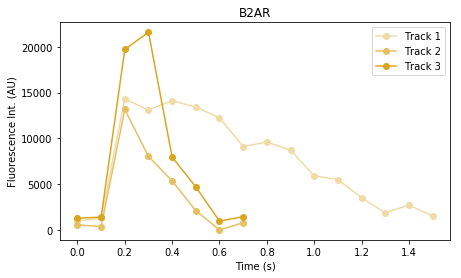

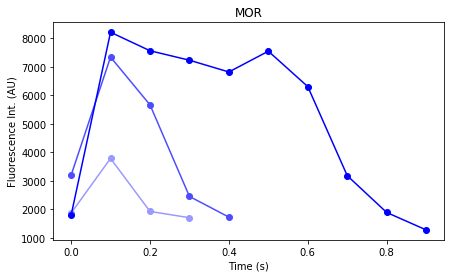

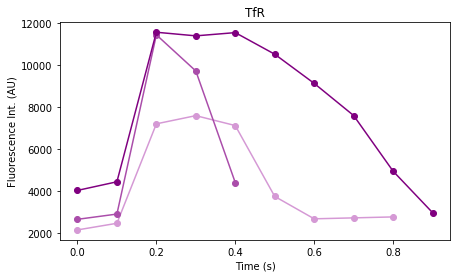

In [152]:
pal = sns.color_palette(np.array(sns.light_palette('goldenrod',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(b2_events, 576, 2, -1, buffer = b2_buffer, label = 'Track 1')
plot_track(b2_events, 370, 1, -1, buffer = b2_buffer, label = 'Track 2')
plot_track(b2_events, 320, 8, -1, buffer = b2_buffer, label = 'Track 3')
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.legend()
plt.title('B2AR')

pal = sns.color_palette(np.array(sns.light_palette('blue',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(mor_events, 351, 0, -1)
plot_track(mor_events, 295, 0, -1)
plot_track(mor_events, 138, 0, -1)
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.title('MOR')

pal =  sns.color_palette(np.array(sns.light_palette('purple',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(tfr_events, 81, 1, -1)
plot_track(tfr_events, 1057, 5, -1)
plot_track(tfr_events, 1062, 9, -1)
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.title('TfR')

In [249]:
b2_movies = np.load('B2Cell3_events.npy')
b2_movies = pd.DataFrame(b2_movies, columns = ['eventid', 'isPuff', 'frameno', 'isOrig', 'col', 'row', 'value'])

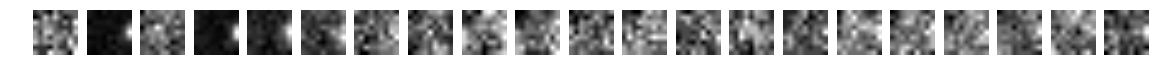

In [250]:
track_num = 320
track = b2_movies.loc[(b2_movies['eventid'] == track_num), :].copy()
track['value'] = preprocessing.minmax_scale(track['value'].values.reshape(-1, 1))
frames = np.unique(track['frameno'])
fig, axs = plt.subplots(1,len(frames), figsize=(20,10))
for ax, frameno in enumerate(frames):
    frame = track.loc[(track['frameno'] == frameno), 'value']
    mapped_frame = frame.values.reshape((9,9))
    mapped_frame = transform.rescale(mapped_frame,20,mode='edge', multichannel=False, anti_aliasing=False)
    axs[ax].imshow(mapped_frame, cmap='gray')
    axs[ax].axis('off')

In [7]:
print(np.sum((labeled['isPuff'] == 1.)))

1121


Even if we manually split puffs into these distinct classes, we still lose out on a host of quantitative information. If we're looking for differences in exocytic events between cargo, this information is ideal for determining these differences. To establish whether there are quantitative differences between cargo, we first sought to look at differences between hand scored events. With this labeled dataset in hand, we were then able to build a machine learning classifier that could distinguish bona fide exocytic events from noise in novel movies without the need for manual scoring.

# Methods and Results

To simplify the process of detecting exocytic events, we made use of the detection portion of the cmeAnalysis package (Aguet et al. 2013) to detect diffraction limited spots in pre-existing exocytic recycling movies that we've recorded. This detection easily found bona fide events, but also identified many events in our movies that were clearly noise. To distinguish real events from noise, we hand scored over 30,000 events across 19 different cells for 3 different cargo. For cargo, we selected two model GPCRs of interest to our lab, the B2 adrenergic receptor and the mu opioid receptor. We also included the transferrin receptor in our analysis, as it is a clasically recycling cargo. The scored data set contains a total of 1300 exocytic events (467 B2AR, 218 MOR, 615 TfR). For our hand scored events, we evaluated the events on 4 quantitiative measures:

* lifetime: the duration over which the event occurs
* plateau: the time between initial event appearance before the receptor begins to diffuse into the cell membrane. We use this is a metric for the time an event spends before it the exocytic pore is fully open
* tau: the half-life of the event's decay after it's initial diffusion. We use this as a measurement of the rate of collapse or vesicle emptying into the plasma membrane
* integrated density: the total fluorescence value of the event over it's lifetime. This is a function of the bleaching rate of the cargo, the total amount of cargo in the event, and the diffusion rate of the cargo coming from the event.

When evaluated based on these criteria, distinctions in cargo populations can be clearly seen.

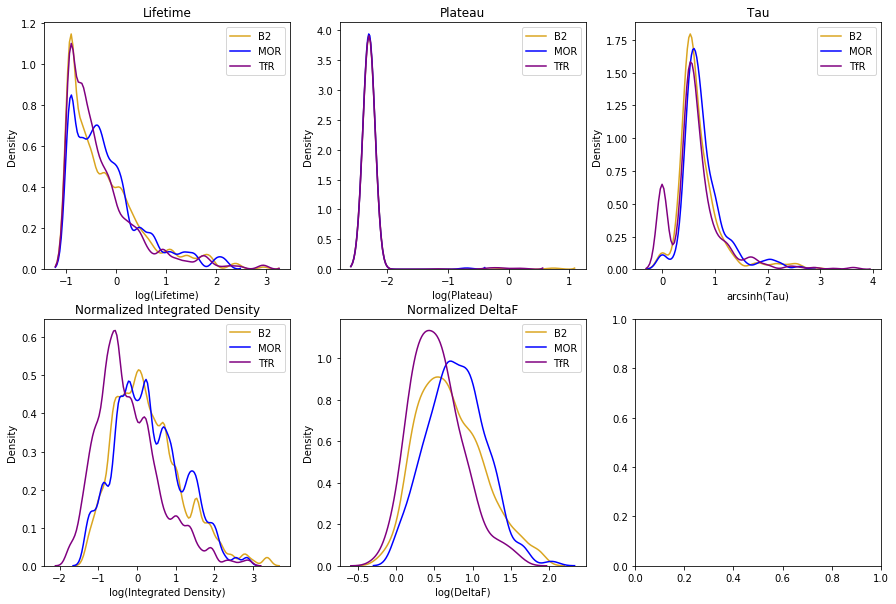

In [8]:
puff_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

fig, axs = plt.subplots(2,3, figsize=(15,10))

axs = axs.ravel()

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'lifetime_s']), 
                label=cargo, 
                bw=0.1,
                shade = False,
                ax = axs[0])
    
axs[0].set_title('Lifetime')
axs[0].set_xlabel('log(Lifetime)')
axs[0].set_ylabel('Density')

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'plateau']), 
                label=cargo, 
                bw=0.1,
                shade = False,
                ax=axs[1])
    
axs[1].set_title('Plateau')
axs[1].set_xlabel('log(Plateau)')
axs[1].set_ylabel('Density')

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.arcsinh(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'tau']), 
                label=cargo, 
                bw=0.1,
                shade = False,
                ax=axs[2])
    
axs[2].set_title('Tau')
axs[2].set_xlabel('arcsinh(Tau)')
axs[2].set_ylabel('Density')

for cargo in ['B2', 'MOR', 'TfR']:
    subset = labeled.loc[labeled['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        densities = subset.loc[subset['cell'] == cell, 'int_density']
        labeled.loc[(labeled['cargo'] == cargo) & (labeled['cell'] == cell), 'norm_density'] = densities/np.nanmean(densities)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_density']), 
                bw = 0.1, 
                label = cargo,
                shade = False,
                ax=axs[3])
    
axs[3].set_title('Normalized Integrated Density')
axs[3].set_xlabel('log(Integrated Density)')
axs[3].set_ylabel('Density')

for cargo in ['B2', 'MOR', 'TfR']:
    subset = labeled.loc[labeled['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        deltafs = subset.loc[subset['cell'] == cell, 'deltaf']
        labeled.loc[(labeled['cargo'] == cargo) & (labeled['cell'] == cell), 'norm_deltaf'] = deltafs/np.nanmean(deltafs)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_deltaf']), 
                bw = 0.1, 
                label = cargo,
                shade = False,
                ax=axs[4])
    
axs[4].set_title('Normalized DeltaF')
axs[4].set_xlabel('log(DeltaF)')
axs[4].set_ylabel('Density')

plt.show()

All of these features are somwhat dependent on each other. Because of those dependencies, it is helpful to look at the relation of puffs in a dimensionally scaled space. To do this, we create compute a distance matrix. Here we used two potential methods, MDS and tSNE.

In [9]:
puffs_for_ds = labeled.loc[labeled['isPuff'] == 1., ['cargo', 'cell', 'lifetime_s', 'plateau', 'tau', 'norm_density', 'norm_deltaf']]

puffs_for_ds.loc[:, 'lifetime_s'] = np.log(puffs_for_ds.loc[:, 'lifetime_s'])
puffs_for_ds.loc[:, 'plateau'] = np.log(puffs_for_ds.loc[:, 'plateau'])
puffs_for_ds.loc[:, 'norm_density'] = np.log(puffs_for_ds.loc[:, 'norm_density'])
puffs_for_ds.loc[:, 'norm_deltaf'] = np.log(puffs_for_ds.loc[:, 'norm_deltaf'])
puffs_for_ds.loc[:, 'tau'] = np.arcsinh(puffs_for_ds.loc[:, 'tau'])

scaled_puffs = preprocessing.scale(puffs_for_ds[puffs_for_ds.columns[2:]])

In [10]:
tsne_class = sklearn.manifold.TSNE(random_state=237)
fit_tsne = tsne_class.fit_transform(scaled_puffs)

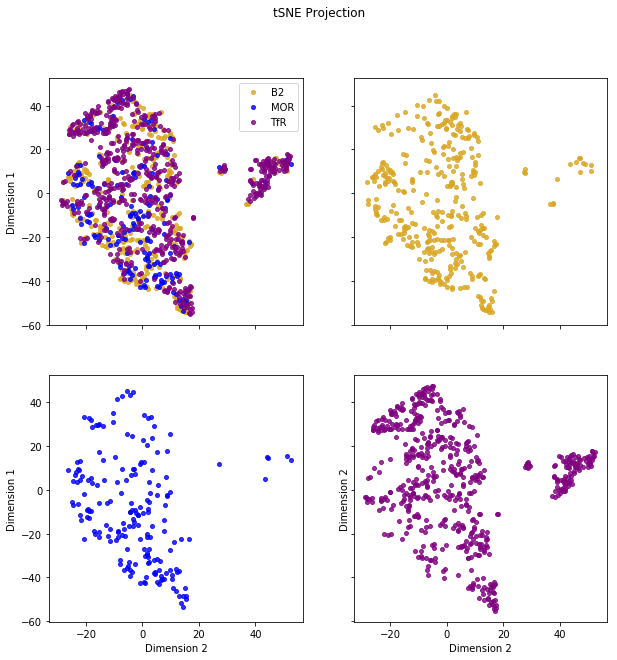

In [11]:
puff_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

fig, axs = plt.subplots(2,2, figsize=(10,10), sharex = True, sharey = True)

axs = axs.ravel()

plt.suptitle('tSNE Projection')

for axis, cargo in enumerate(['B2','MOR','TfR']):
    filt = (puffs_for_ds['cargo'] == cargo)
    axs[0].plot(fit_tsne[filt,0],
                fit_tsne[filt,1],
                marker='o', markersize='4', ls='None', alpha = .8, label=cargo)
    axs[axis+1].plot(fit_tsne[filt,0],
                   fit_tsne[filt,1],
                   marker='o', markersize='4', ls='None', alpha = .8, label=cargo, color=puff_pal[axis])
    plt.xlabel('Dimension 2')
    plt.ylabel('Dimension 1')

axs[0].legend()
axs[0].set_ylabel('Dimension 1')
axs[2].set_ylabel('Dimension 1')
axs[3].set_ylabel('Dimension 2')
axs[2].set_xlabel('Dimension 2')
plt.show()

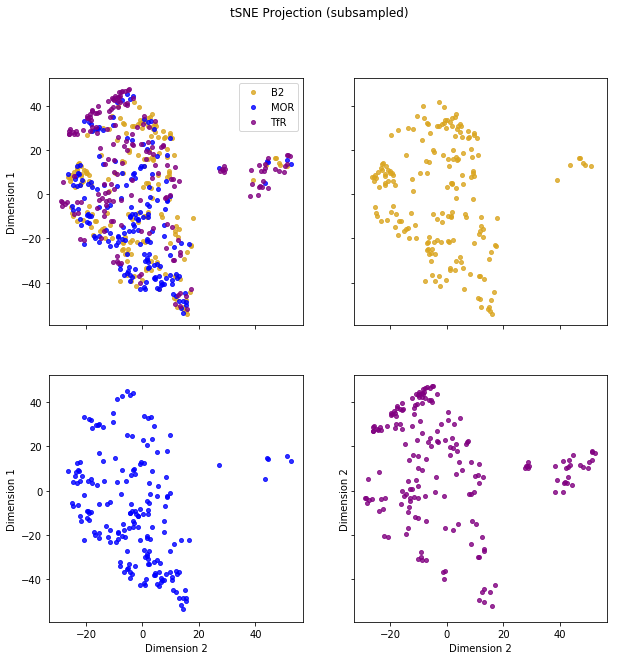

In [12]:
puff_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

fig, axs = plt.subplots(2,2, figsize=(10,10), sharex = True, sharey = True)

axs = axs.ravel()

for axis, cargo in enumerate(['B2','MOR','TfR']):
    filt = (puffs_for_ds['cargo'] == cargo)
    filt_tsne = fit_tsne[filt,:]
    idx = np.random.choice(187, size = 187, replace = False)
    axs[0].plot(filt_tsne[idx,0],
                filt_tsne[idx,1],
                marker='o', markersize='4', ls='None', alpha = .8, label=cargo)
    axs[axis+1].plot(filt_tsne[idx,0],
                   filt_tsne[idx,1],
                   marker='o', markersize='4', ls='None', alpha = .8, label=cargo, color=puff_pal[axis])
    plt.xlabel('Dimension 2')
    plt.ylabel('Dimension 1')

axs[0].legend()
axs[0].set_ylabel('Dimension 1')
axs[2].set_ylabel('Dimension 1')
axs[3].set_ylabel('Dimension 2')
axs[2].set_xlabel('Dimension 2')
plt.suptitle('tSNE Projection (subsampled)')
plt.show()

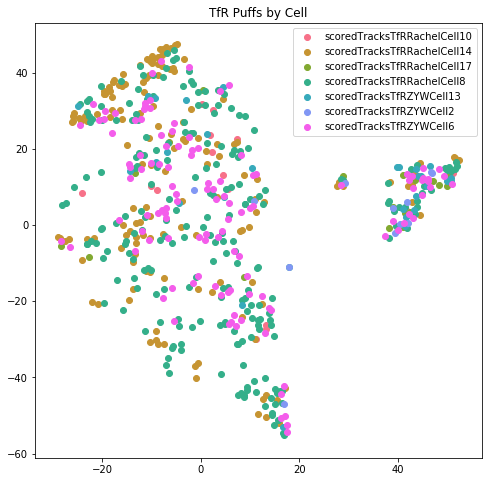

In [13]:
filt = (puffs_for_ds['cargo'] == 'TfR')
sns.set_palette(sns.color_palette("husl", len(np.unique(puffs_for_ds.loc[filt, 'cell']))))
fig = plt.figure(figsize = (8,8))
for cell in np.unique(puffs_for_ds.loc[filt, 'cell']):
    cell_filt = filt & (puffs_for_ds['cell'] == cell)
    plt.scatter(fit_tsne[cell_filt,0],
                fit_tsne[cell_filt,1],
                alpha = 1,
                label = cell)
plt.legend()
plt.title('TfR Puffs by Cell')
plt.show()

## Training a machine learning classifier to identify exocytic events

The above differences in cargo are suggestive of different pools of exocytic vesicles, perhaps originating from distinct endosomal locations. In order to test this hypothesis, it is important to gather a large dataset in every condition. This is limiting given the time consuming nature of identifying single exocytic events. To allow more rapid acquisition of data across various conditions, we engineered features from the scored dataset. The features we engineered separated bona fide exocytic events from the large amount of noise identified during initial point detection. 

In [14]:
training_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 'tnpeaks', 'lifetime_s', 
          'percentC','MotionAnalysis', 'deltaf', 'SNR', 'tau', 'ttp', 'RSSm', 'global_background', 'plateau', 
          'int_density', 'nSeg', 'isPSFm', 'mask_Arm', 'maskNm', 'pval_Arm', 'maxAc']

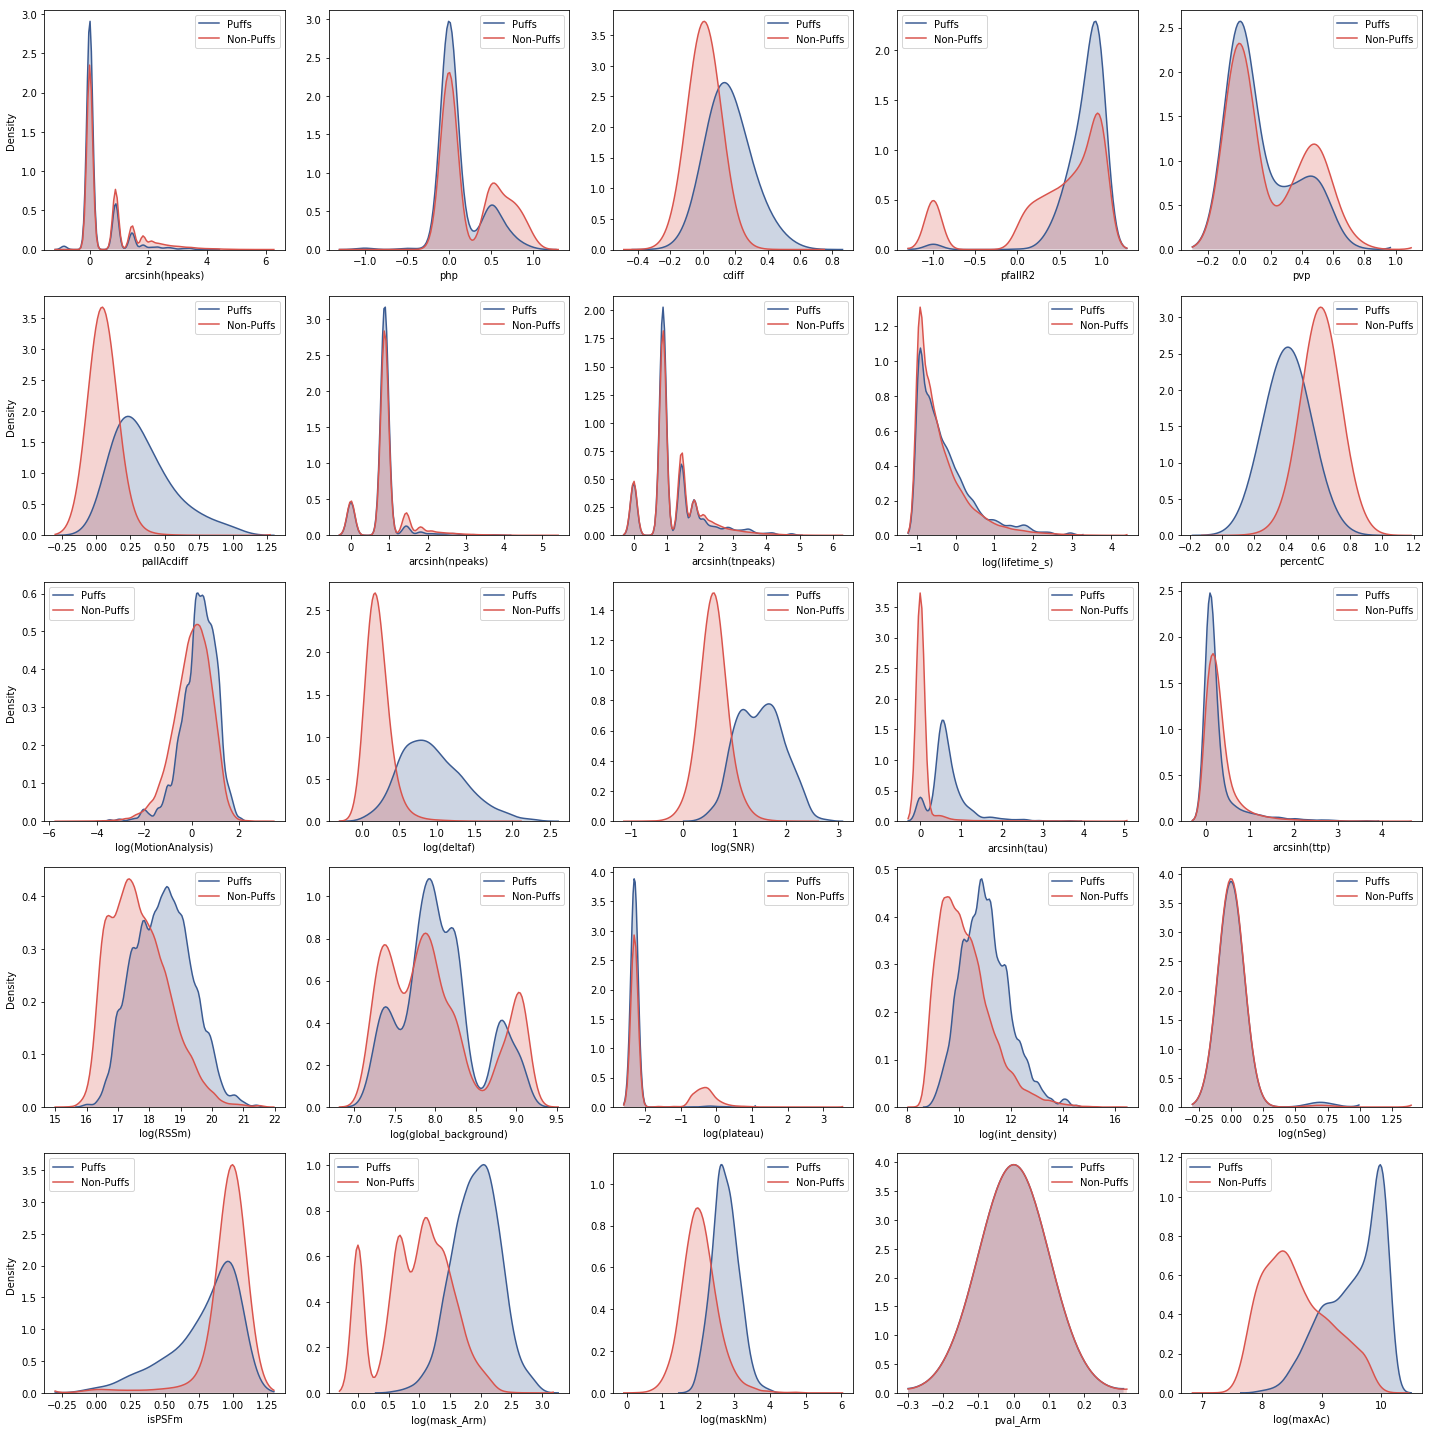

In [15]:
sns.set_palette(sns.color_palette([sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red']]))

nrows = 5

fig, axes = plt.subplots(math.ceil(np.shape(training_fields)[0]/nrows),
                         nrows)
fig.set_size_inches(20,20)

for counter, feature in enumerate(training_fields):
    if  counter % nrows == 0:
        axes.ravel()[counter].set_ylabel('Density ')
    axes.ravel()[counter].set_xlabel(feature)
    dist = labeled[feature]
    puff_dist = dist[labeled['isPuff'] == 1.]
    nonpuff_dist = dist[labeled['isPuff'] == 2.]
    dist = dist[~np.isnan(dist)]
    puff_dist = puff_dist[~np.isnan(puff_dist)]
    nonpuff_dist = nonpuff_dist[~np.isnan(nonpuff_dist)]
    
    if (np.max(dist) > 1):
        if np.any(dist <= 0):
            sns.kdeplot(np.arcsinh(puff_dist), 
                        label = 'Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('arcsinh(' + feature + ')')
            sns.kdeplot(np.arcsinh(nonpuff_dist), 
                        label = 'Non-Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('arcsinh(' + feature + ')')
        else:
            sns.kdeplot(np.log(puff_dist), 
                        label = 'Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('log(' + feature + ')')
            sns.kdeplot(np.log(nonpuff_dist), 
                        label = 'Non-Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('log(' + feature + ')')
    else:
        sns.kdeplot(puff_dist, 
                     label = 'Puffs',
                     bw = 0.1,
                        shade = True,
                     ax = axes.ravel()[counter])
        sns.kdeplot(nonpuff_dist, 
                     label = 'Non-Puffs',
                     bw = 0.1,
                        shade = True,
                     ax = axes.ravel()[counter])

plt.tight_layout()

After building features, we selected a RandomForest machine learning algorithm in order to build our classifier. To evaluate the performance of our model, we used a round robin design - for each classifier in the dataset, we build a classifier trained on all other cells in the labeled dataset, and then evaluated it against the held out cell.

<function matplotlib.pyplot.show>

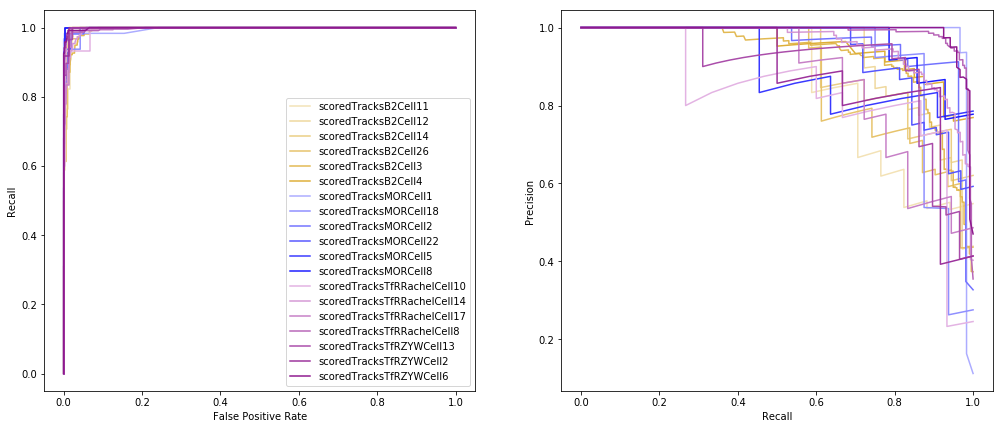

In [16]:
pal = sns.light_palette('goldenrod',9)[2:-1] + sns.light_palette('blue',9)[2:-1] + sns.light_palette('purple',10)[2:-1]
sns.set_palette(pal)

plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

for cell in np.unique(labeled['cell']):
    held_data = labeled.loc[labeled['cell'] == cell]
    train_data = labeled.loc[labeled['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['isPuff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['isPuff'], probas_[:,0],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    labeled.loc[labeled['cell'] == cell, 'proba'] = probas_[:,0]
                             
ax1.legend()
plt.show

Ideally, this classifier would allow us to use its reported probabilities for each event to predict the 'puff-ness' of that event. However, to correctly interpret those probabiilities, we need to make sure that their meaning is consistent across cells. To accomplish this, two issues need to be tackled:

1. Differences in base rate: Since puffs are a small fraction of the total events detected in our cells, subtlye differences in the rate of puffs per cell have large effects on the overally probability distribution.
2. Differences in predicted probability distributions: Adjusting our predictions after base rate correction relies on all cells having similarly shaped predicted probability distributions.

For point 1, the difference in base rates is easily demonstrated between cells:

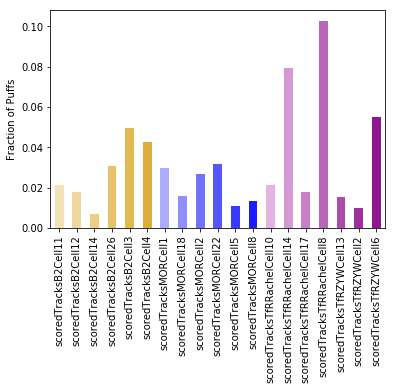

In [17]:
cell_res = pd.DataFrame({'cell': np.unique(labeled['cell'])})

for cell in cell_res['cell']:
    cell_puffs = labeled.loc[labeled['cell'] == cell, 'isPuff']
    cell_res.loc[cell_res['cell'] == cell , 'n'] = cell_puffs.shape[0]
    cell_res.loc[cell_res['cell'] == cell , 'true_count'] = np.sum(cell_puffs == 1.)
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(cell_puffs == 1.)

pal = sns.light_palette('goldenrod',9)[2:-1] + sns.light_palette('blue',9)[2:-1] + sns.light_palette('purple',10)[2:-1]
sns.set_palette(pal)
ax = cell_res.plot.bar(x = 'cell', y = 'true_frac', legend = False)
ax.set_xlabel('')
ax.set_ylabel('Fraction of Puffs')
plt.show()

Similarly, the difference in predicted probability distributions are readily apparent:

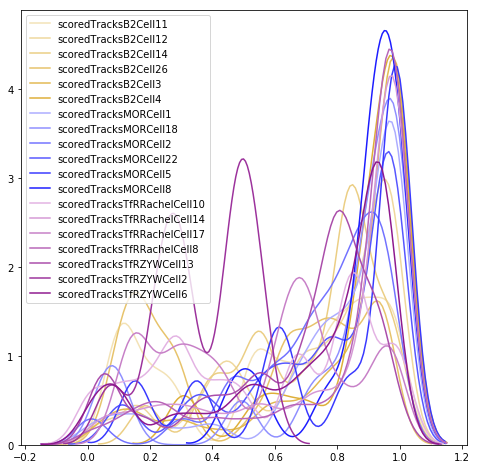

In [18]:
plt.figure(figsize = (8,8))

for cell in cell_res['cell']:
    sns.kdeplot(labeled.loc[(labeled['cell'] == cell) & (labeled['isPuff'] == 1.), 'proba'], bw='0.05', label=cell)

We devised a strategy whereby we can correct for label shift between cells by relying on the predicted probability distributions across those cells. First, we evaluated each cell in the round robin classifier demonstrated above. Then, we evaluate the the similarity of a given cell's predicted probability distribution with all the other cells (using the Wasserstein distance between each distrubtion). We then select the three most similar cells by this metric in the dataset, and use the ground truth of those cells to calibrate the probabilities reported by the classifier for the cell of interest. Finally, we use black box shift estimation to predict the base rate in the cell of interest.

In [19]:
def base_rate_correction(train_y, train_f, test_f, thresh=0.5):
    _, train_props = np.unique(train_y, return_counts=True)
    train_props = train_props*1.0/len(train_y)
    train_conf = pd.crosstab(index=train_f>thresh, columns=train_y)
    train_conf = train_conf*1.0/train_conf.values.sum()
    _, test_pred_props = np.unique(test_f>thresh, return_counts=True)
    test_pred_props = test_pred_props*1.0/len(test_f)
    w = np.matmul(np.linalg.solve(train_conf, np.identity(2)), test_pred_props)
    muy = train_props*w
    return muy[0]

In [20]:
def get_close_cells(test_puff_probs, train_puff_probs, cell_memberships, threshold=0.1, k=3):
    cell_list = np.unique(cell_memberships)
    dists = [wd(test_puff_probs[test_puff_probs > threshold],
                train_puff_probs[cell_memberships == c][train_puff_probs[cell_memberships == c] > threshold]) for c in cell_list]
    return cell_list[np.argsort(dists)][0:3]

In [21]:
def cell_matching_correction(test_puff_probs, train_puff_probs, train_puff_labels, cell_memberships):
    close_cells = get_close_cells(test_puff_probs, train_puff_probs, cell_memberships)
    close_train_probs = train_puff_probs[np.isin(cell_memberships, close_cells)]
    close_train_labels = train_puff_labels[np.isin(cell_memberships, close_cells)]
    
    calibrater = LogisticRegression(C = 1000000, random_state=237)
    calibrater.fit(close_train_probs.reshape(-1, 1), 
                       close_train_labels)
    
    # correct original probabilities based on calibration
    calibrated_test_probs = calibrater.predict_proba(test_puff_probs.reshape(-1, 1))[:,0]
    calibrated_train_probs = calibrater.predict_proba(close_train_probs.reshape(-1, 1))[:,0]
    
    return base_rate_correction(close_train_labels, calibrated_train_probs, calibrated_test_probs)

In [22]:
bar = progressbar.ProgressBar()

for cell in bar(np.unique(labeled['cell'])):
    # split dataset into x and y
    held = labeled.loc[labeled['cell'] == cell, :].copy()
    train = labeled.loc[labeled['cell'] != cell, :].copy()
    
    # build an initial random forest classifier
    # straightorward prediction of puff/nonpuff using training cells
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train[training_fields], train['isPuff'])
    
    #evaluate data on classifier
    test_puff_probs = classifier.predict_proba(held[training_fields])[:,0]
    train_puff_probs = classifier.oob_decision_function_[:,0]
    train_puff_labels = train['isPuff']
    cell_memberships = train['cell']
    
    #Correct probabilities using cell matching
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(held['isPuff'] == 1.)
    cell_res.loc[cell_res['cell'] == cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == cell, 'est_frac_corr'] = cell_matching_correction(test_puff_probs, 
                                                                                       train_puff_probs, 
                                                                                       train_puff_labels, 
                                                                                       cell_memberships)

100% (19 of 19) |#########################| Elapsed Time: 0:09:24 Time: 0:09:24


In [91]:
def make_close_cell(test, train):
    test = labeled.loc[labeled['cell'] == 'scoredTracksB2Cell11', :].copy()
    train = labeled.loc[labeled['cell'] != 'scoredTracksB2Cell11', :].copy()
    test['label'] = 1
    train['label'] = 0
    combined = pd.concat([test, train])
    calibrater = LogisticRegression(C = 1000000, random_state=237)
    calibrater.fit(combined[training_fields], combined['label'])
    np.random.seed(237)
    weights = calibrater.predict_proba(train[training_fields])[:,1]
    weights = weights/np.sum(weights)
    idx = np.random.choice(train.index.values, size=10*test.shape[0], p=weights)
    new_cell = labeled.loc[idx,:].copy()
    return new_cell

In [92]:
def event_matching_correction(test, train, test_puff_probs):
    close_cell = make_close_cell(test, train)
    close_train_probs = close_cell['proba']
    close_train_labels = close_cell['isPuff']
    
    calibrater = LogisticRegression(C = 1000000, random_state=237)
    calibrater.fit(close_train_probs.values.reshape(-1, 1), 
                   close_train_labels)
    
    # correct original probabilities based on calibration
    calibrated_test_probs = calibrater.predict_proba(test_puff_probs.reshape(-1, 1))[:,0]
    calibrated_train_probs = calibrater.predict_proba(close_train_probs.values.reshape(-1, 1))[:,0]
    
    return base_rate_correction(close_train_labels, calibrated_train_probs, calibrated_test_probs)

In [93]:
bar = progressbar.ProgressBar()

for cell in bar(np.unique(labeled['cell'])):
    # split dataset into x and y
    held = labeled.loc[labeled['cell'] == cell, :].copy()
    train = labeled.loc[labeled['cell'] != cell, :].copy()
    
    # build an initial random forest classifier
    # straightorward prediction of puff/nonpuff using training cells
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train[training_fields], train['isPuff'])
    
    #evaluate data on classifier
    test_puff_probs = classifier.predict_proba(held[training_fields])[:,0]
    train_puff_probs = classifier.oob_decision_function_[:,0]
    train['proba'] = train_puff_probs
    train_puff_labels = train['isPuff']
    cell_memberships = train['cell']
    
    #Correct probabilities using cell matching
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(held['isPuff'] == 1.)
    cell_res.loc[cell_res['cell'] == cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == cell, 'est_frac_corr'] = cell_matching_correction(test_puff_probs, 
                                                                                       train_puff_probs, 
                                                                                       train_puff_labels, 
                                                                                       cell_memberships)
    cell_res.loc[cell_res['cell'] == cell, 'est_frac_fake_corr'] = event_matching_correction(held,
                                                                                             train,
                                                                                             test_puff_probs)

100% (19 of 19) |#########################| Elapsed Time: 0:09:43 Time: 0:09:43


To evaluate the accuracy of these base rate corrections, we can then look at the difference of the predicted base rate from the actual base rate. We compared a simple base rate prediction whereby we just looked at the mean value of the predicted probabilities (est_frac_raw_mean) and a base rate prediction where we used an arbitrary cutoff value and looked for the fraction of events above that probability cutoff (est_frac_raw_thres). Overall, the corrections using cell matching (est_frac_corr) yielded more accurate results than either of the simple corrections.

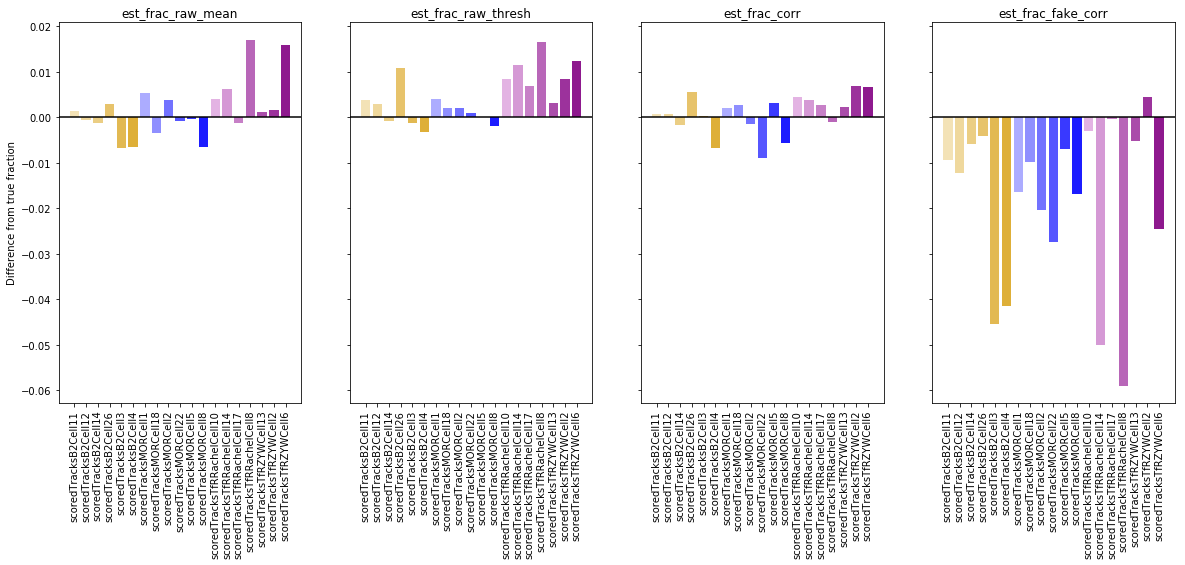

In [94]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize=(20,7))
axs[0].set_ylabel('Difference from true fraction')

for ax, est in enumerate(['est_frac_raw_mean', 'est_frac_raw_thresh', 'est_frac_corr', 'est_frac_fake_corr']):
    pred_diff = cell_res['true_frac'] - cell_res[est]
    for counter, cell in enumerate(cell_res['cell']):
        axs[ax].bar(cell, pred_diff[counter])
    axs[ax].set_xticklabels(cell_res['cell'], rotation='vertical')
    axs[ax].axhline(y=0, color = 'black')
    axs[ax].set_title(est)

Finally, we used these base rate estimates to correct the predicted probabilities generated by the classifier. We used the predicted base rate as a prior for each event in a given cell, and then compared that to the base rate in the training data selected as 'closest' based on probability distribution. We then use these priors to correct the calibrated probabilities.

In [23]:
def score_correct(probs_old, pi_old, pi_new):
    return pi_new/pi_old*probs_old/(pi_new/pi_old*probs_old + (1-pi_new)/(1-pi_old)*(1-probs_old))

In [24]:
def matching_score_correction(test_puff_probs, train_puff_probs, train_puff_labels, cell_memberships):
    close_cells = get_close_cells(test_puff_probs, train_puff_probs, cell_memberships)
    close_train_probs = train_puff_probs[np.isin(cell_memberships, close_cells)]
    close_train_labels = train_puff_labels[np.isin(cell_memberships, close_cells)]
    
    calibrater = LogisticRegression(C = 1000000, random_state=237)
    calibrater.fit(close_train_probs.reshape(-1, 1), 
                       close_train_labels)
    
    # correct original probabilities based on calibration
    calibrated_test_probs = calibrater.predict_proba(test_puff_probs.reshape(-1, 1))[:,0]
    calibrated_train_probs = calibrater.predict_proba(close_train_probs.reshape(-1, 1))[:,0]
    
    prior = base_rate_correction(close_train_labels, calibrated_train_probs, calibrated_test_probs)
    train_prior = np.mean(train_puff_labels == 1.)
    
    return score_correct(calibrated_test_probs, train_prior, prior)

100% (19 of 19) |#########################| Elapsed Time: 0:08:54 Time: 0:08:54


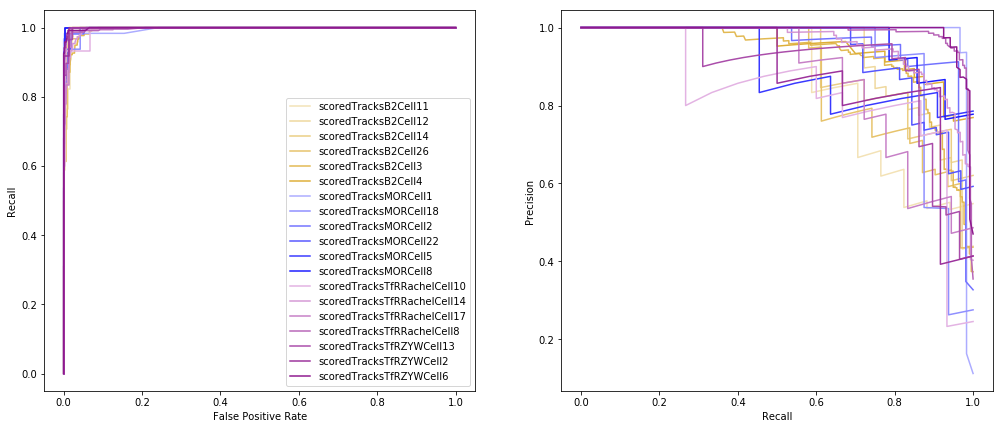

In [25]:
bar = progressbar.ProgressBar()

plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

for cell in bar(np.unique(labeled['cell'])):
    # split dataset into x and y
    held = labeled.loc[labeled['cell'] == cell, :].copy()
    train = labeled.loc[labeled['cell'] != cell, :].copy()
    
    # build an initial random forest classifier
    # straightorward prediction of puff/nonpuff using training cells
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train[training_fields], train['isPuff'])
    
    #evaluate data on classifier
    test_puff_probs = classifier.predict_proba(held[training_fields])[:,0]
    train_puff_probs = classifier.oob_decision_function_[:,0]
    train_puff_labels = train['isPuff']
    cell_memberships = train['cell']
    
    proba_corr = matching_score_correction(test_puff_probs, 
                                           train_puff_probs, 
                                           train_puff_labels, 
                                           cell_memberships)
    
    fpr, tpr , thresholds= roc_curve(held['isPuff'], proba_corr, pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held['isPuff'], proba_corr ,pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    
    ### Here we try different predictions of the true proportion of puffs
    labeled.loc[labeled['cell'] == cell, 'proba_corr'] = proba_corr
    
ax1.legend()
plt.show()

This configuration yields overall more homegenous performance between cells, as well as better performance on the most diverse cells. We can see by comparing initial and corrected probabilities that some cells have very little shift, while several cells shift pretty dramatically.

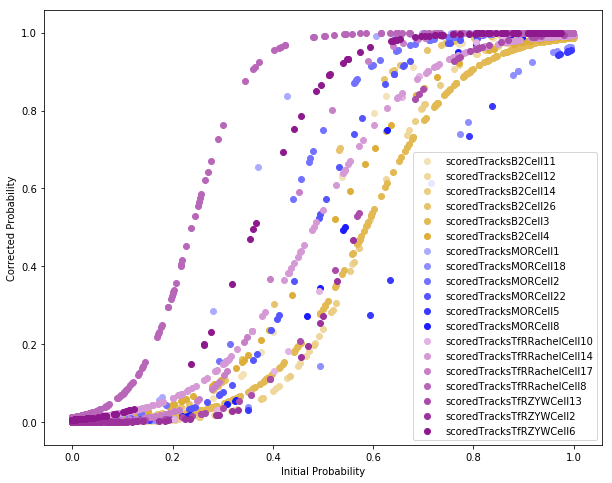

In [26]:
plt.figure(figsize=(10,8))

for cell in cell_res['cell']:
    plt.scatter(labeled.loc[labeled['cell'] == cell, 'proba'], labeled.loc[labeled['cell'] == cell, 'proba_corr'], label=cell)
    
plt.xlabel('Initial Probability')
plt.ylabel('Corrected Probability')
plt.legend()
plt.show()

We can also see that the heterogeneity in the predicted probabilities of puffs across cells is also somewhat relieved using this method.

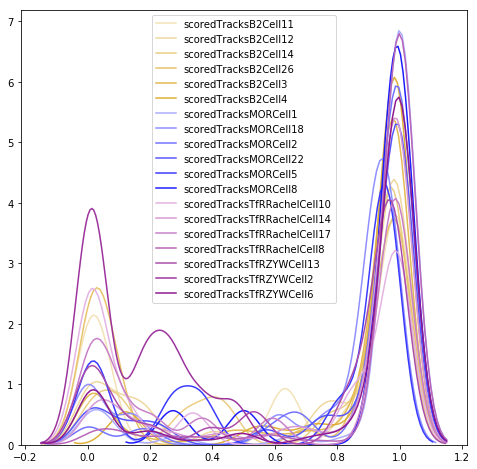

In [27]:
plt.figure(figsize = (8,8))

for cell in cell_res['cell']:
    sns.kdeplot(labeled.loc[(labeled['cell'] == cell) & (labeled['isPuff'] == 1.), 'proba_corr'], bw='0.05', label=cell)

Given the reliability and generalizability demonstrated above, we then constructed a single classifier based off of all the labeled data that can be used on novel unlabeled data. You can see of the training features which featured prominently in the classifier.

In [28]:
classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
classifier.fit(labeled[training_fields], labeled['isPuff'])

order = np.argsort(-classifier.feature_importances_)
for ind in order:
    print(training_fields[ind] + '\t' + str(classifier.feature_importances_[ind]))

deltaf	0.20908852340267353
tau	0.16179114575806347
pallAcdiff	0.1324928016274958
cdiff	0.10417856807432734
SNR	0.10203312893864437
percentC	0.06407163784215834
mask_Arm	0.05542113191551542
maxAc	0.036832594248437094
maskNm	0.030904316258501527
php	0.012512840396918606
pfallR2	0.01233714531690001
isPSFm	0.010014601940270257
int_density	0.009184779001126308
hpeaks	0.009046842439665585
RSSm	0.00830072004986675
global_background	0.007804629533684299
lifetime_s	0.007448528947082522
ttp	0.005978918350951019
MotionAnalysis	0.0055368499716997085
tnpeaks	0.004758664728304469
npeaks	0.004275518240390986
plateau	0.0025299435160047326
pvp	0.0022474340925941493
pval_Arm	0.0010144435396495365
nSeg	0.00019429186907428172


We can use the OOB probabilities from the above classifier to evaluate its accuracy across the training data set when the classifier's probabilities are corrected in the same manner as above.

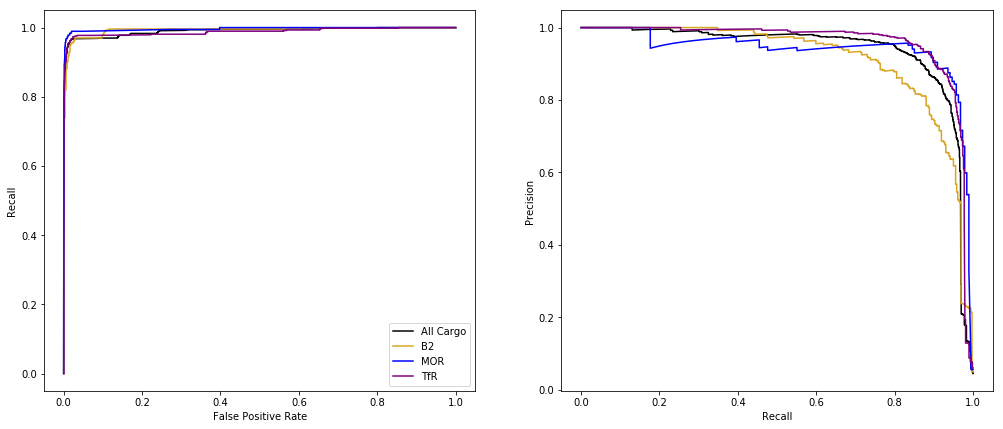

In [29]:
puff_pal = sns.color_palette(['black','goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

for cell in np.unique(labeled['cell']):
    target_oob = classifier.oob_decision_function_[labeled['cell'] == cell, 0]
    train_oob = classifier.oob_decision_function_[labeled['cell'] != cell, 0]
    train_labels = labeled.loc[labeled['cell'] != cell, 'isPuff']
    cell_memberships = labeled.loc[labeled['cell'] != cell, 'cell']
    
    labeled.loc[labeled['cell'] == cell, 'oob_corr'] = matching_score_correction(target_oob, 
                                                                                 train_oob, 
                                                                                 train_labels, 
                                                                                 cell_memberships)
    
plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

fpr, tpr , thresholds= roc_curve(labeled['isPuff'], labeled['oob_corr'], pos_label = 1)
ax1.plot(fpr, tpr, label='All Cargo')
precision, recall, thresholds = precision_recall_curve(labeled['isPuff'], labeled['oob_corr'], pos_label = 1)
ax2.plot(recall, precision, label='All Cargo')

for cargo in np.unique(labeled['cargo']):
    probas = labeled.loc[labeled['cargo'] == cargo, 'oob_corr']
    fpr, tpr , thresholds= roc_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
    ax1.plot(fpr, tpr, label=cargo)
    precision, recall, thresholds = precision_recall_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
    ax2.plot(recall, precision, label=cargo)
    
ax1.legend()

In [30]:
thresh = 0.003
print(((labeled['oob_corr'] <= thresh) & (labeled['isPuff'] == 1.)).nonzero()[0].shape)
print(((labeled['oob_corr'] >= thresh) & (labeled['isPuff'] == 2.)).nonzero()[0].shape)
print(((labeled['oob_corr'] >= thresh)).nonzero()[0].shape)

(8,)
(9370,)
(10483,)


In [31]:
dims = ['lifetime_s', 'plateau', 'tau', 'norm_density', 'norm_deltaf']

labeled_scaled = labeled.loc[labeled['oob_corr'] >= 0.006, :].copy()
weights = labeled_scaled['oob_corr']

labeled_scaled.loc[:, 'lifetime_s'] = np.log(labeled_scaled.loc[:, 'lifetime_s'])
labeled_scaled.loc[:, 'plateau'] = np.log(labeled_scaled.loc[:, 'plateau'])
labeled_scaled.loc[:, 'norm_density'] = np.log(labeled_scaled.loc[:, 'norm_density'])
labeled_scaled.loc[:, 'norm_deltaf'] = np.log(labeled_scaled.loc[:, 'norm_deltaf'])
labeled_scaled.loc[:, 'tau'] = np.arcsinh(labeled_scaled.loc[:, 'tau'])

scaled = preprocessing.scale(labeled_scaled[dims])
manifold = sklearn.manifold.TSNE(random_state = 237, method = 'exact')
coords_all = manifold.fit_transform(scaled)

In [32]:
manifold = sklearn.manifold.TSNE(random_state = 237, method = 'exact')
coords_puffs = manifold.fit_transform(scaled[labeled_scaled['isPuff'] == 1., :])

manifold = sklearn.manifold.TSNE(random_state = 237, method = 'exact')
coords_weighted = manifold.fit_transform(scaled, weights = weights)

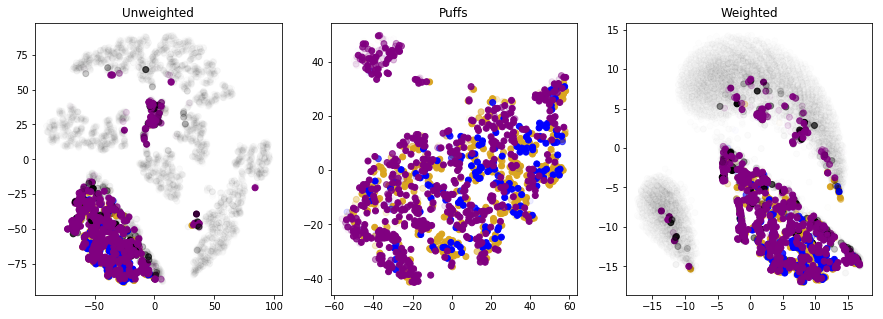

In [33]:
color_dict = {'B2' : [0.8549019607843137, 0.6470588235294118, 0.12549019607843137, 1], 
              'TfR' : [0.5019607843137255, 0.0, 0.5019607843137255, 1], 
              'MOR' : [0, 0, 1, 1]}
colors_ = np.array([color_dict[el] for el in labeled_scaled['cargo']])
colors_[labeled_scaled['isPuff'] == 2., :] = [0, 0, 0, 1]
colors_[:, 3] = weights

fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].scatter(coords_all[:,0], coords_all[:,1], 
               color = colors_)
axs[0].set_title('Unweighted')
axs[1].scatter(coords_puffs[:,0], coords_puffs[:,1], 
               color = colors_[labeled_scaled['isPuff'] == 1., :])
axs[1].set_title('Puffs')
axs[2].scatter(coords_weighted[:,0], coords_weighted[:,1], 
               color = colors_)
axs[2].set_title('Weighted')
plt.show()

Satisfied with the performance of the classifier, we then used it to evaluated unlabeled data.

## Evaluating new data on the classifier
With a trained classifier, we can now detect puffs in a novel data set. We selected previously generated exocytosis recordings from each of the evaluated cargo (59 cells for B2AR, 20 cells for MOR, 19 cells for TfR) and evaluated them on the classifier, thresholding based on the above to select for detected events that are likely to be puffs.

In [34]:
train_probas = classifier.oob_decision_function_[:,0]
train_labels = labeled['isPuff']
cell_memberships = labeled['cell']

for cargo in np.unique(novel['cargo']):
    for cell in np.unique(novel.loc[novel['cargo'] == cargo, 'cell']):
        test_probas = classifier.predict_proba(novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), training_fields])[:,0]
        test_probas_corr = matching_score_correction(test_probas, 
                                                     train_probas, 
                                                     train_labels, 
                                                     cell_memberships)
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'proba'] = test_probas
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'proba_corr'] = test_probas_corr

We can then use the probabilities above to estimate population distributions of our variables of interest. Below, we compare distributions generated with no weights and those weighted by the baserate corrected and logistic regression calibrated probabilities. 

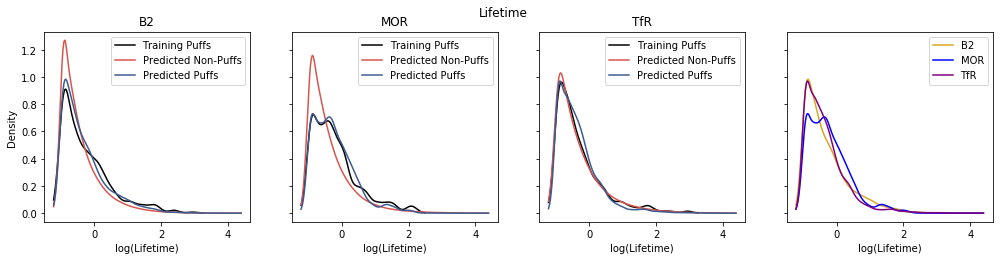

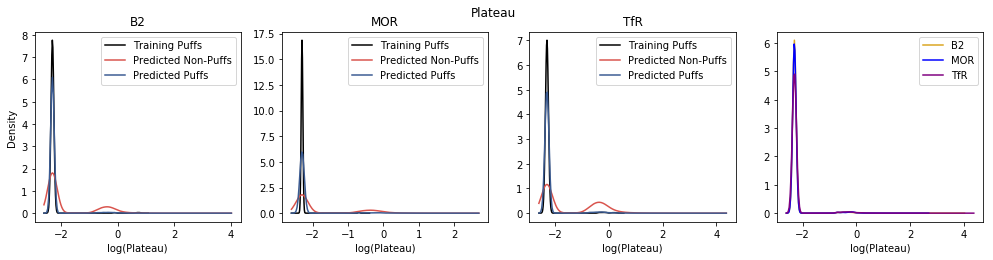

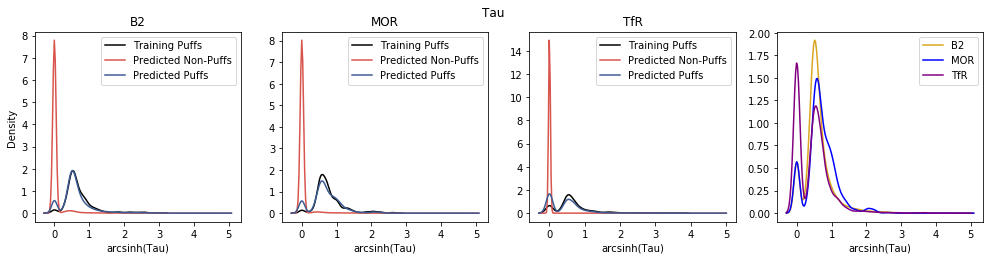

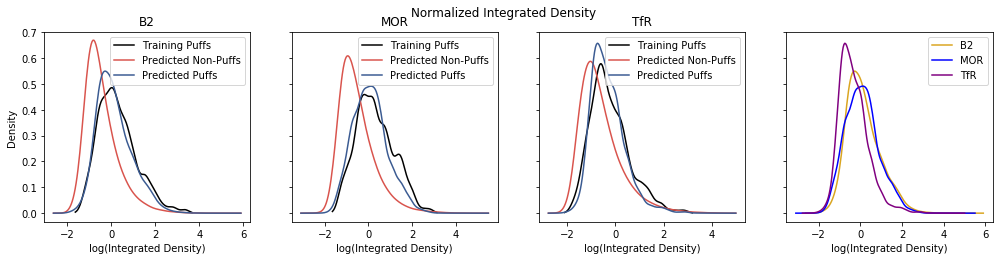

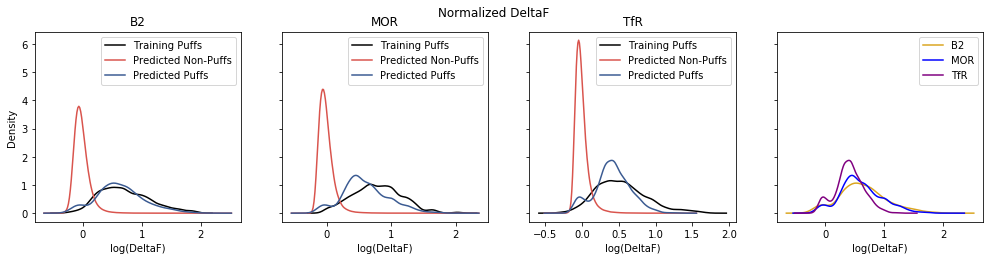

In [35]:
bw = 0.2
grid = 200

puff_pal = sns.color_palette(['black', sns.xkcd_rgb['pale red'], sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['minty green']])
cargo_pal = ['goldenrod', 'blue', 'purple']
sns.set_palette(puff_pal)

fig, ax = plt.subplots(1,4,figsize=(17,3.5), sharey = True)

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    truescores = np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'lifetime_s'].values)
    scores = np.log(novel.loc[(novel['cargo'] == cargo), 'lifetime_s'].values)
    
    gridsize = np.linspace(np.min(truescores) - 0.3, np.max(truescores) + 0.3, grid)
    true_kde = gaussian_kde(dataset = truescores,
                                         bw_method = bw)
    ax[axis].plot(gridsize, true_kde.evaluate(gridsize), label = 'Training Puffs')
    
    gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)
    
    puff_weights = novel.loc[(novel['cargo'] == cargo), 'proba_corr'].values
    nonpuff_weights = 1-puff_weights
    puff_weights = puff_weights / np.sum(puff_weights)
    nonpuff_weights = nonpuff_weights / np.sum(nonpuff_weights)
    
    nonpuffs_kde = gaussian_kde(dataset = scores,
                                             bw_method = bw,
                                             weights = nonpuff_weights)
    puffs_kde = gaussian_kde(dataset = scores,
                                          bw_method = bw,
                                          weights = puff_weights)
    ax[axis].plot(gridsize, nonpuffs_kde.evaluate(gridsize), label = 'Predicted Non-Puffs')
    ax[axis].plot(gridsize, puffs_kde.evaluate(gridsize), label = 'Predicted Puffs')
    ax[axis].set_title(cargo)
    ax[axis].legend()
    ax[axis].set_xlabel('log(Lifetime)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
        
    ax[3].plot(gridsize, puffs_kde.evaluate(gridsize), label = cargo, color = cargo_pal[axis])
    ax[3].legend()
    ax[3].set_xlabel('log(Lifetime)')

plt.suptitle('Lifetime')

fig, ax = plt.subplots(1,4,figsize=(17,3.5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    truescores = np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'plateau'].values)
    scores = np.log(novel.loc[(novel['cargo'] == cargo), 'plateau'].values)
    
    gridsize = np.linspace(np.min(truescores) - 0.3, np.max(truescores) + 0.3, grid)
    true_kde = gaussian_kde(dataset = truescores,
                                         bw_method = bw)
    ax[axis].plot(gridsize, true_kde.evaluate(gridsize), label = 'Training Puffs')
    
    gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)
    
    puff_weights = novel.loc[(novel['cargo'] == cargo), 'proba_corr'].values
    nonpuff_weights = 1-puff_weights
    puff_weights = puff_weights / np.sum(puff_weights)
    nonpuff_weights = nonpuff_weights / np.sum(nonpuff_weights)
    
    nonpuffs_kde = gaussian_kde(dataset = scores,
                                          bw_method = bw,
                                          weights = nonpuff_weights)
    puffs_kde = gaussian_kde(dataset = scores,
                                             bw_method = bw,
                                             weights = puff_weights)
    ax[axis].plot(gridsize, nonpuffs_kde.evaluate(gridsize), label = 'Predicted Non-Puffs')
    ax[axis].plot(gridsize, puffs_kde.evaluate(gridsize), label = 'Predicted Puffs')
    ax[axis].set_title(cargo)
    ax[axis].legend()
    ax[axis].set_xlabel('log(Plateau)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
    ax[3].plot(gridsize, puffs_kde.evaluate(gridsize), label = cargo, color = cargo_pal[axis])
    ax[3].legend()
    ax[3].set_xlabel('log(Plateau)')

plt.suptitle('Plateau')

fig, ax = plt.subplots(1,4,figsize=(17,3.5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    truescores = np.arcsinh(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'tau'].values)
    scores = np.arcsinh(novel.loc[(novel['cargo'] == cargo), 'tau'].values)
    
    gridsize = np.linspace(np.min(truescores) - 0.3, np.max(truescores) + 0.3, grid)
    true_kde = gaussian_kde(dataset = truescores,
                                         bw_method = bw)
    ax[axis].plot(gridsize, true_kde.evaluate(gridsize), label = 'Training Puffs')
    
    gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)
    
    puff_weights = novel.loc[(novel['cargo'] == cargo), 'proba_corr'].values
    nonpuff_weights = 1-puff_weights
    puff_weights = puff_weights / np.sum(puff_weights)
    nonpuff_weights = nonpuff_weights / np.sum(nonpuff_weights)
    
    nonpuffs_kde = gaussian_kde(dataset = scores,
                                          bw_method = bw,
                                          weights = nonpuff_weights)
    puffs_kde = gaussian_kde(dataset = scores,
                                             bw_method = bw,
                                             weights = puff_weights)
    ax[axis].plot(gridsize, nonpuffs_kde.evaluate(gridsize), label = 'Predicted Non-Puffs')
    ax[axis].plot(gridsize, puffs_kde.evaluate(gridsize), label = 'Predicted Puffs')
    ax[axis].set_title(cargo)
    ax[axis].legend()
    ax[axis].set_xlabel('arcsinh(Tau)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
    ax[3].plot(gridsize, puffs_kde.evaluate(gridsize), label = cargo, color = cargo_pal[axis])
    ax[3].legend()
    ax[3].set_xlabel('arcsinh(Tau)')
        
plt.suptitle('Tau')

fig, ax = plt.subplots(1,4,figsize=(17,3.5), sharey = True)

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    
    for cell in np.unique(novel.loc[novel['cargo'] == cargo, 'cell']):
        densities = novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'int_density']
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'norm_density'] = densities/np.nanmean(densities)
    
    truescores = np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_density'].values)
    scores = np.log(novel.loc[(novel['cargo'] == cargo), 'norm_density'].values)
    
    gridsize = np.linspace(np.min(truescores) - 0.3, np.max(truescores) + 0.3, grid)
    true_kde = gaussian_kde(dataset = truescores,
                                         bw_method = bw)
    ax[axis].plot(gridsize, true_kde.evaluate(gridsize), label = 'Training Puffs')
    
    gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)
    
    puff_weights = novel.loc[(novel['cargo'] == cargo), 'proba_corr'].values
    nonpuff_weights = 1-puff_weights
    puff_weights = puff_weights / np.sum(puff_weights)
    nonpuff_weights = nonpuff_weights / np.sum(nonpuff_weights)
    
    nonpuffs_kde = gaussian_kde(dataset = scores,
                                          bw_method = bw,
                                          weights = nonpuff_weights)
    puffs_kde = gaussian_kde(dataset = scores,
                                             bw_method = bw,
                                             weights = puff_weights)
    ax[axis].plot(gridsize, nonpuffs_kde.evaluate(gridsize), label = 'Predicted Non-Puffs')
    ax[axis].plot(gridsize, puffs_kde.evaluate(gridsize), label = 'Predicted Puffs')
    ax[axis].set_title(cargo)
    ax[axis].legend()
    ax[axis].set_xlabel('log(Integrated Density)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
        
    ax[3].plot(gridsize, puffs_kde.evaluate(gridsize), label = cargo, color = cargo_pal[axis])
    ax[3].legend()
    ax[3].set_xlabel('log(Integrated Density)')

plt.suptitle('Normalized Integrated Density')

fig, ax = plt.subplots(1,4,figsize=(17,3.5), sharey = True)

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    
    for cell in np.unique(novel.loc[novel['cargo'] == cargo, 'cell']):
        deltafs = novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'deltaf']
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'norm_deltaf'] = deltafs/np.nanmean(deltafs)
    
    truescores = np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_deltaf'].values)
    scores = np.log(novel.loc[(novel['cargo'] == cargo), 'norm_deltaf'].values)
    
    gridsize = np.linspace(np.min(truescores) - 0.3, np.max(truescores) + 0.3, grid)
    true_kde = gaussian_kde(dataset = truescores,
                                         bw_method = bw)
    ax[axis].plot(gridsize, true_kde.evaluate(gridsize), label = 'Training Puffs')
    
    gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)
    
    puff_weights = novel.loc[(novel['cargo'] == cargo), 'proba_corr'].values
    nonpuff_weights = 1-puff_weights
    puff_weights = puff_weights / np.sum(puff_weights)
    nonpuff_weights = nonpuff_weights / np.sum(nonpuff_weights)
    
    nonpuffs_kde = gaussian_kde(dataset = scores,
                                          bw_method = bw,
                                          weights = nonpuff_weights)
    puffs_kde = gaussian_kde(dataset = scores,
                                             bw_method = bw,
                                             weights = puff_weights)
    ax[axis].plot(gridsize, nonpuffs_kde.evaluate(gridsize), label = 'Predicted Non-Puffs')
    ax[axis].plot(gridsize, puffs_kde.evaluate(gridsize), label = 'Predicted Puffs')
    ax[axis].set_title(cargo)
    ax[axis].legend()
    ax[axis].set_xlabel('log(DeltaF)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
    ax[3].plot(gridsize, puffs_kde.evaluate(gridsize), label = cargo, color = cargo_pal[axis])
    ax[3].legend()
    ax[3].set_xlabel('log(DeltaF)')

plt.suptitle('Normalized DeltaF')
plt.show()

Given that we can accurately recapitulate population dynamics of known cargoes using this method, we then sought to see if we could capture previous established results using this classifier and then extend them to identify populations of exocytic events that differ between treatment conditions. We selected a recycling experiment used in Vistein & Puthenveedu 2013. In this experiment, we previously demonstrated the the recycling of the B2AR is actin dependent, but it is not for a phospho mutant of the receptor, B2AR-SSAA.

In [36]:
vistein2013 = pd.read_csv('latA.csv')
vistein2013 = vistein2013.drop('Unnamed: 0',1)
vistein2013 = vistein2013.loc[~((vistein2013['cell'] == 'Field5_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field1_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field7_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field9_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field10_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field11_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'WT_B2') & (vistein2013['cell'] == 'Field14_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field12_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field14_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field16_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field15_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field17_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field18_0.1s'))]
vistein2013 = vistein2013.loc[~((vistein2013['cargo'] == 'SSAA_B2') & (vistein2013['cell'] == 'Field19_0.1s'))]

In [37]:
train_probas = classifier.oob_decision_function_[:,0]
train_labels = labeled['isPuff']
cell_memberships = labeled['cell']

for cargo in np.unique(vistein2013['cargo']):
    for treatment in np.unique(vistein2013.loc[vistein2013['cargo'] == cargo, 'treatment']):
        for cell in np.unique(vistein2013.loc[(vistein2013['cargo'] == cargo) & (vistein2013['treatment'] == treatment), 'cell']):
            print(cargo + treatment + cell)
            cell_filter = ((vistein2013['cargo'] == cargo) & 
                           (vistein2013['treatment'] == treatment) & 
                           (vistein2013['cell'] == cell))
            
            cell_densities = vistein2013.loc[cell_filter, 'int_density']
            vistein2013.loc[cell_filter, 'norm_density'] = cell_densities/np.nanmean(cell_densities)
            cell_deltafs = vistein2013.loc[cell_filter, 'deltaf']
            vistein2013.loc[cell_filter, 'norm_deltaf'] = cell_deltafs/np.nanmean(cell_deltafs)
            
            
            test_probas = classifier.predict_proba(vistein2013.loc[(vistein2013['cargo'] == cargo) & (vistein2013['treatment'] == treatment) & (vistein2013['cell'] == cell), training_fields])[:,0]
            test_probas_corr = matching_score_correction(test_probas, 
                                                         train_probas, 
                                                         train_labels, 
                                                         cell_memberships)
            vistein2013.loc[cell_filter, 'proba'] = test_probas
            vistein2013.loc[cell_filter, 'proba_corr'] = test_probas_corr
            vistein2013.loc[cell_filter, 'weights'] = test_probas_corr / np.sum(test_probas_corr)

SSAA_B2IsoField10_0.1s
SSAA_B2IsoField11_0.1s
SSAA_B2IsoField13_0.1s
SSAA_B2IsoField1_0.1s
SSAA_B2IsoField2_0.1s
SSAA_B2IsoField3_0.1s
SSAA_B2IsoField4_0.1s
SSAA_B2IsoField6_0.1s
SSAA_B2IsoField7_0.1s
SSAA_B2IsoField8_0.1s
SSAA_B2IsoField9_0.1s
SSAA_B2LatAField10_0.1s
SSAA_B2LatAField11_0.1s
SSAA_B2LatAField13_0.1s
SSAA_B2LatAField1_0.1s
SSAA_B2LatAField2_0.1s
SSAA_B2LatAField3_0.1s
SSAA_B2LatAField4_0.1s
SSAA_B2LatAField6_0.1s
SSAA_B2LatAField7_0.1s
SSAA_B2LatAField8_0.1s
SSAA_B2LatAField9_0.1s
WT_B2IsoField12_0.1s
WT_B2IsoField13_0.1s
WT_B2IsoField2_0.1s
WT_B2IsoField3_0.1s
WT_B2IsoField4_0.1s
WT_B2IsoField6_0.1s
WT_B2IsoField8_0.1s
WT_B2LatAField12_0.1s
WT_B2LatAField13_0.1s
WT_B2LatAField2_0.1s
WT_B2LatAField3_0.1s
WT_B2LatAField4_0.1s
WT_B2LatAField6_0.1s
WT_B2LatAField8_0.1s


In [38]:
vistein2013.groupby(['cargo', 'cell', 'treatment'])['proba_corr'].sum()

cargo    cell          treatment
SSAA_B2  Field10_0.1s  Iso          10.223907
                       LatA         10.984636
         Field11_0.1s  Iso          10.697909
                       LatA         -0.424276
         Field13_0.1s  Iso           5.525887
                       LatA         -0.434674
         Field1_0.1s   Iso           7.875400
                       LatA          8.211245
         Field2_0.1s   Iso           8.680249
                       LatA          5.054679
         Field3_0.1s   Iso           6.037905
                       LatA          7.704818
         Field4_0.1s   Iso          27.135683
                       LatA         66.635470
         Field6_0.1s   Iso           1.875710
                       LatA          2.766096
         Field7_0.1s   Iso           5.265481
                       LatA          2.196620
         Field8_0.1s   Iso           7.751604
                       LatA          2.331290
         Field9_0.1s   Iso          15.227446
 

In [39]:
rachel_events = pd.read_csv('/Volumes/Coatamer/Users/weinberz/Google Drive/CMU/PuthenveeduLab/Automated Puffs Method Manuscript/rachel_b2.csv')
percent_events = pd.DataFrame(vistein2013.loc[vistein2013['treatment'] == 'LatA', :].groupby(['cargo', 'cell'])['proba_corr'].sum() / 
                              vistein2013.loc[vistein2013['treatment'] == 'Iso', :].groupby(['cargo', 'cell',])['proba_corr'].sum()).reset_index()
percent_events = pd.concat([percent_events, rachel_events])

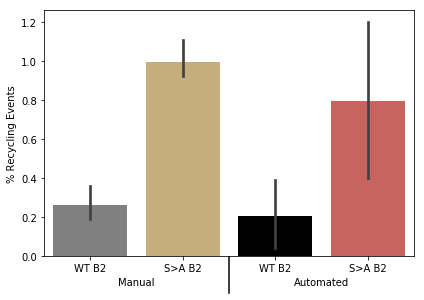

In [40]:
fig = plt.figure()
sns.set_palette(['gray', sns.xkcd_rgb['tan'], 'black', sns.xkcd_rgb['pale red']])
ax = sns.barplot(data = percent_events, 
                 x = 'cargo', 
                 y = 'proba_corr',
                 ci = 95,
                 order = ['WT', 'SSAA', 'WT_B2', 'SSAA_B2'])
ax.set_ylabel('% Recycling Events')
ax.set_xticklabels(['WT B2', 'S>A B2', 'WT B2', 'S>A B2'])
ax.set_xlabel('')
ax.text(0.3, -0.15, 'Manual')
ax.text(2.2, -0.15, 'Automated')
line = plt.Line2D([0.5, 0.5], [-0.005, -0.15], color='black', transform=ax.transAxes)
line.set_clip_on(False)
ax.add_line(line)
plt.tight_layout()
plt.show()

/Volumes/Coatamer/Users/weinberz/Google Drive/Code/MATLAB/puffsAnalysis/gaussian_kde.py:288: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n


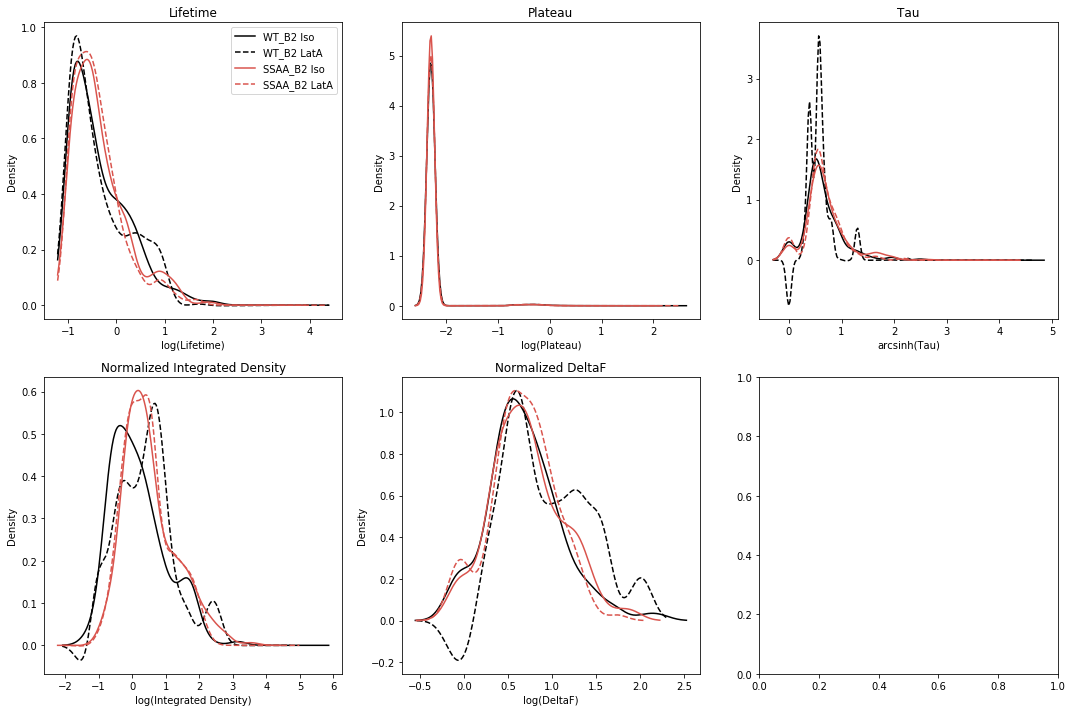

In [41]:
pal = sns.color_palette(['black', 'black', sns.xkcd_rgb['pale red'], sns.xkcd_rgb['pale red']])
linestyle = ['solid', 'dashed', 'solid', 'dashed']

bw = 0.3
grid = 200

conditions = list(itertools.product(['WT_B2','SSAA_B2'],['Iso','LatA']))
func_feature_pairs = [(np.log, 'lifetime_s'),
                      (np.log, 'plateau'),
                      (np.arcsinh, 'tau'),
                      (np.log, 'norm_density'),
                      (np.log, 'norm_deltaf')]

fig, axs = plt.subplots(2,3, figsize=(15,10))

axs = axs.ravel()

for group, (cargo, treatment) in enumerate(conditions):
    filter_ = ((vistein2013['cargo'] == cargo) & 
               (vistein2013['treatment'] == treatment))
    label = cargo + ' ' + treatment
    
    for axis, (transform_func, feature) in enumerate(func_feature_pairs):
        scores = transform_func(vistein2013.loc[filter_, feature].values)

        gridsize = np.linspace(np.min(scores) - 0.3, np.max(scores) + 0.3, grid)

        weights = vistein2013.loc[filter_, 'proba_corr'].values
        weights = weights / np.sum(weights)
        
        kde = gaussian_kde(dataset = scores,
                           bw_method = bw,
                           weights = weights)
        axs[axis].plot(gridsize, kde.evaluate(gridsize), label = label, color = pal[group], linestyle= linestyle[group])
    
axs[0].set_title('Lifetime')
axs[0].set_xlabel('log(Lifetime)')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].set_title('Plateau')
axs[1].set_xlabel('log(Plateau)')
axs[1].set_ylabel('Density')

axs[2].set_title('Tau')
axs[2].set_xlabel('arcsinh(Tau)')
axs[2].set_ylabel('Density')

axs[3].set_title('Normalized Integrated Density')
axs[3].set_xlabel('log(Integrated Density)')
axs[3].set_ylabel('Density')

axs[4].set_title('Normalized DeltaF')
axs[4].set_xlabel('log(DeltaF)')
axs[4].set_ylabel('Density')
plt.tight_layout()
plt.show()

In [ ]:
samples = vistein2013[['lifetime_s', 'plateau', 'tau', 'norm_density', 'norm_deltaf']].copy()
samples.loc[:, 'lifetime_s'] = np.log(samples.loc[:, 'lifetime_s'])
samples.loc[:, 'plateau'] = np.log(samples.loc[:, 'plateau'])
samples.loc[:, 'norm_density'] = np.log(samples.loc[:, 'norm_density'])
samples.loc[:, 'norm_deltaf'] = np.log(samples.loc[:, 'norm_deltaf'])
samples.loc[:, 'tau'] = np.arcsinh(samples.loc[:, 'tau'])
samples = preprocessing.scale(samples)
tsne_class = sklearn.manifold.TSNE(random_state=237, method = 'exact')
fit_tsne = tsne_class.fit_transform(samples, weights=vistein2013['proba_corr'])

pal = {'WT_B2' : 'black', 'SSAA_B2' : sns.xkcd_rgb['pale red']}
marker = {'Iso' : '.', 'LatA' : '+'}

fig, axs = plt.subplots(2,2, figsize=(10,10), sharex = True, sharey = True)

plt.suptitle('Weighted by proba_corr')

for idx, sample in enumerate(vistein2013.itertuples()):
    cargo = getattr(sample, 'cargo')
    treatment = getattr(sample, 'treatment')
    score = getattr(sample, 'proba_corr')
    if cargo == 'WT_B2':
        row = 0
    else:
        row = 1
    if treatment == 'Iso':
        col = 0
    else:
        col = 1
    
    axs[row, col].scatter(fit_tsne[idx,0],
                          fit_tsne[idx,1],
                          marker = marker[treatment],
                          color = pal[cargo],
                          alpha = score)

axs[0,0].set_title('WT_B2 + Iso')
axs[0,1].set_title('WT_B2 + LatA')
axs[1,0].set_title('SSAA_B2 + Iso')
axs[1,1].set_title('SSAA_B2 + LatA')
axs[0, 0].set_ylabel('Dimension 1')
axs[1, 0].set_ylabel('Dimension 1')
axs[1, 0].set_xlabel('Dimension 2')
axs[1, 1].set_xlabel('Dimension 2')
plt.show()